## Determination of Negative Modes

The purpose of this notebook is to determine the negative modes of the connected wormhole solution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.special import ellipkinc
import sympy

sympy.init_printing()

### Preliminaries

In [2]:
r, r_0, L, lam = sympy.symbols("r r_0 L lambda")

In [3]:
# spherical part of the metric
g = sympy.Function("g")(r)
dg = sympy.diff(g, r)

g_sol = r ** 2 + r_0 ** 2
dg_sol = sympy.diff(g_sol, r)

def g_func(r, r_0):
    return r ** 2 + r_0 ** 2
def dg_func(r):
    return 2 * r

In [4]:
# radial part of the metric
f = sympy.Function("f")(r)
df = sympy.diff(f, r)

f_sol = (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
df_sol = sympy.diff(f_sol, r)

def f_func(r, r_0, L):
    return (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
def df_func(r, L):
    return 2 * r / L ** 2

In [5]:
# gauge field
Phi = sympy.Function("Phi")(r)
dPhi = sympy.diff(Phi, r)
ddPhi = sympy.diff(dPhi, r)

In [6]:
def get_a(b):
    """Get a based on b."""
    return np.sqrt(2 * b ** 2 + 1)

def get_phi_star(b):
    """Get phi star based on b."""
    return b * np.sqrt(b ** 2 + 1) / 2

def get_ellip_m_param(a, b):
    """Get the elliptic integral parameter m based on a and b."""
    return 1 - a ** 2 / b ** 2

In [7]:
def phi_of_r(r, b, L):
    """Get gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)
    return phi_star * np.cosh((2 / b) * ellipkinc(phi, m))

In [8]:
def dphi_of_r(r, b, L):
    """Get radial derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan(r / (L * a))

    a_term = a ** 2 * L ** 2 + r ** 2
    b_term = b ** 2 * L ** 2 + r ** 2

    return 2 * L * phi_star * np.sinh((2 / b) * ellipkinc(phi, m)) / np.sqrt(a_term * b_term)

In [9]:
def ddphi_of_r(r, b, L):
    """Get second derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)

    sin_part = np.sinh((2 / b) * ellipkinc(phi, m))
    cos_part = np.cosh((2 / b) * ellipkinc(phi, m))
    a_term = a ** 2 * L ** 2 + r ** 2
    b_term = b ** 2 * L ** 2 + r ** 2

    first_term = 2 * L * a_term ** 2 * cos_part / b_term
    second_term = r * (a_term + b_term) * sin_part / (b_term / a_term) ** (3. / 2)

    return 2 * L * phi_star * (first_term - second_term) / a_term ** 3

In [10]:
q = sympy.Function("q")(r)
dq = sympy.diff(q, r)
ddq = sympy.diff(dq, r)

K = sympy.Function("K")(r)
dK = sympy.diff(K, r)
K_sol = 6 * L ** 2 * r ** 2 / (r ** 2 - g * L ** 2 * dPhi ** 2)

V = sympy.Function("V")(r)
V_sol = (4 * K_sol / g) * ((2 * g) / (L ** 2 * f * r) * ((L ** 2 * (r - L ** 2 * Phi * dPhi) + g * (r - 2 * L ** 2 * Phi * dPhi)) / (r ** 2 - g * L ** 2 * dPhi ** 2)) - 1)

### Eigenvalue Problem

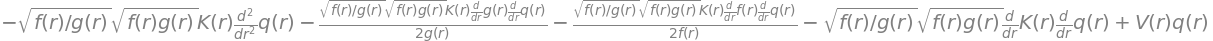

In [11]:
eigen = -sympy.sqrt(f / g) * sympy.diff(sympy.sqrt(f * g) * K * dq, r) + V * q
eigen.expand()

Simplify.

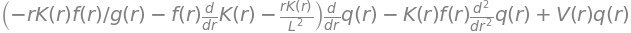

In [12]:
eigen = -r * f * K * dq / g - f * K * ddq - f * dK * dq + V * q - r * K * dq / L ** 2
eigen.collect([q, dq])

Separate the terms.

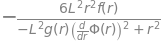

In [13]:
ddq_factor = eigen.coeff(ddq).subs({K: K_sol})
ddq_factor

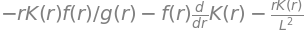

In [14]:
dq_factor = eigen.coeff(dq)
dq_factor

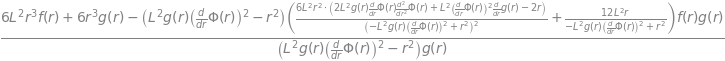

In [15]:
dq_factor = dq_factor.subs({K: K_sol}).simplify()
dq_factor

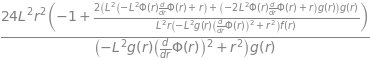

In [16]:
q_factor = eigen.coeff(q).subs({V: V_sol})
q_factor

#### Discretize

The idea is to tune r_0, the length of the wormhole throat, and determine the eigenvalue. Since r_0 = bL, this amounts to tuning b. Therefore, all functions should depend on b.

For numerical convenience, we will make the change of variables r = r_0 * y / (1 - y) = bLy / (1 - y).

First, form a grid.

In [17]:
def cheb(N, x_minus, x_plus):
    def get_a_j(x, j):
        a = 1
        for k in range(len(x)):
            if k != j:
                a *= x[j] - x[k]
        return a

    x = (x_plus + x_minus) / 2 + (x_plus - x_minus) / 2 * np.cos(np.pi * np.arange(0, N + 1) / N)

    D = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        a_i = get_a_j(x, i)
        for j in range(N + 1):
            if j != i:
                # diagonal element
                D[i, i] += 1 / (x[i] - x[j])
                # off diagonal element
                a_j = get_a_j(x, j)
                D[i, j] = a_i / (a_j * (x[i] - x[j]))

    return D, x

In [18]:
y_minus = 0
y_plus = 0.99
N = 50

In [19]:
D, y_vals = cheb(N, y_minus, y_plus)
D

array([[ 1.68383838e+03, -2.04756613e+03,  5.12397082e+02, ...,
         2.02819850e+00, -2.02219719e+00,  1.01010101e+00],
       [ 5.11891533e+02, -2.55692992e+02, -3.41710547e+02, ...,
        -1.01510475e+00,  1.01209815e+00, -5.05549298e-01],
       [-1.28099271e+02,  3.41710547e+02, -6.37961105e+01, ...,
         1.01812926e+00, -1.01510475e+00,  5.07049624e-01],
       ...,
       [-5.07049624e-01,  1.01510475e+00, -1.01812926e+00, ...,
         6.37961105e+01, -3.41710547e+02,  1.28099271e+02],
       [ 5.05549298e-01, -1.01209815e+00,  1.01510475e+00, ...,
         3.41710547e+02,  2.55692992e+02, -5.11891533e+02],
       [-1.01010101e+00,  2.02219719e+00, -2.02819850e+00, ...,
        -5.12397082e+02,  2.04756613e+03, -1.68383838e+03]])

In [20]:
D2 = D @ D
D2

array([[ 1.70050648e+06, -2.70301383e+06,  1.46303698e+06, ...,
         6.82620336e+03, -6.80601722e+03,  3.39965310e+03],
       [ 7.86357611e+05, -1.12482707e+06,  4.08278181e+05, ...,
         5.21171217e+02, -5.19621496e+02,  2.59553146e+02],
       [-4.92932221e+04,  1.89932589e+05, -2.32961939e+05, ...,
        -1.31978548e+02,  1.31580345e+02, -6.57239849e+01],
       ...,
       [-6.57239849e+01,  1.31580345e+02, -1.31978548e+02, ...,
        -2.32961939e+05,  1.89932589e+05, -4.92932221e+04],
       [ 2.59553146e+02, -5.19621496e+02,  5.21171217e+02, ...,
         4.08278181e+05, -1.12482707e+06,  7.86357611e+05],
       [ 3.39965310e+03, -6.80601722e+03,  6.82620336e+03, ...,
         1.46303698e+06, -2.70301383e+06,  1.70050648e+06]])

In [21]:
L_val = 1

In [22]:
def evaluate_factors_numerically(b_val):
    """Evaluate the different factors in the differential equations for a given value of b."""
    ny = len(y_vals)

    ddq_factors_num = np.zeros((ny, ny))
    dq_factors_num = np.zeros((ny, ny))
    q_factors_num = np.zeros((ny, ny), dtype=object)

    r_0_val = b_val * L_val

    for idx, y_val in enumerate(y_vals):
        r_val = r_0_val * y_val / (1 - y_val)

        f_val = f_func(r_val, r_0_val, L_val)
        g_val = g_func(r_val, r_0_val)
        dg_val = dg_func(r_val)
        Phi_val = phi_of_r(r_val, b_val, L_val)
        dPhi_val = dphi_of_r(r_val, b_val, L_val)
        ddPhi_val = ddphi_of_r(r_val, b_val, L_val)

        func_subs = {r: r_val, L: L_val, f: f_val, g: g_val, dg: dg_val, Phi: Phi_val, dPhi: dPhi_val, ddPhi: ddPhi_val}

        ddq_factors_num[idx, idx] = (r_0_val / (r_val + r_0_val) ** 2) ** 2 * ddq_factor.subs(func_subs)
        dq_factors_num[idx, idx] = (r_0_val / (r_val + r_0_val) ** 2) * dq_factor.subs(func_subs)
        q_factors_num[idx, idx] = q_factor.subs(func_subs)

    return ddq_factors_num, dq_factors_num, q_factors_num

In [23]:
def get_A_matrix(b_val, boundary_condition='qdot'):
    """Build the A matrix of the eigenvalue problem given the value for b.

    Args:
        boundary_condition (str): Can be 'q' or 'qdot'. If 'q', then condition q(0) = 0 is used. If 'qdot', then
            q'(0) = 0

    """
    ddq_factors_num, dq_factors_num, q_factors_num = evaluate_factors_numerically(b_val)
    A = ddq_factors_num @ D2 + dq_factors_num @ D + q_factors_num

    if boundary_condition == 'qdot':
        A[-1] = D[-1]
        A = A.astype(float)
    else:
        A[-1] = 0
        A[-1][-1] = 1
        A = A.astype(float)

    return A

In [24]:
def get_B_matrix():
    """Build the B matrix."""
    B = np.identity(len(y_vals))
    B[-1] = 0
    return B

Get the eigenvalues for the general eigenvalue problem A * p = lam * B * p.

In [25]:
b_0_min = 1.251462

In [26]:
A = get_A_matrix(b_0_min)
B = get_B_matrix()
w, vr = linalg.eig(A, B, homogeneous_eigvals=True)

Validate the eigenvalues.

In [27]:
errors = []
for i in range(len(w)):
    errors.append(np.abs(w[1, i] * A @ vr[:, i] - w[0, i] * B @ vr[:, i]).max())
print("Max error =", max(errors))

Max error = 1.5832483768463135e-08


Plot the eigenvectors.

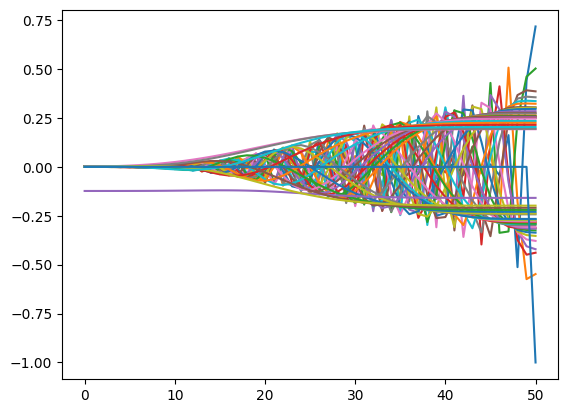

In [28]:
plt.plot(range(w.shape[1]), vr);

In [29]:
def get_eigenvalues_vectors(b_val, boundary_condition='qdot'):
    """Get the eigenvalues given the value for b."""
    A = get_A_matrix(b_val, boundary_condition=boundary_condition)
    B = get_B_matrix()

    w, v = linalg.eig(A, B)

    is_not_complex = ~np.iscomplex(w)
    w = np.real(w[is_not_complex])
    v = v[is_not_complex]

    w_argsort = np.argsort(w)
    w = w[w_argsort]
    v = v[w_argsort]

    return w, v

Get eigenvalues for different values of b for the boundary condition q'(0) = 0.

In [30]:
eigenvalues = []
eigenvectors = []

fracs = [0.8, 0.9, 0.95, 1, 1.05, 1.1]

for frac in fracs:
    w, v = get_eigenvalues_vectors(frac * b_0_min)
    eigenvalues.append(w)
    eigenvectors.append(v)

In [31]:
eigenvalues[0]

array([-1.17910092e+02,  4.74399441e-07,  1.19525357e+01,  1.53987154e+01,
        2.28481884e+01,  3.57907653e+01,  5.47620386e+01,  8.03713812e+01,
        1.13220531e+02,  1.53912098e+02,  2.03077604e+02,  2.61403894e+02,
        3.29883607e+02,  4.09900336e+02,  5.04462917e+02,  6.16624354e+02,
        7.53363200e+02,  9.17395265e+02,  1.12385337e+03,  1.37153538e+03,
        1.70082427e+03,  2.09515200e+03,  2.67004726e+03,  3.35352387e+03,
        4.44195881e+03,  5.71516407e+03,  7.82566915e+03,  1.02666410e+04,
        1.43187658e+04,  1.89974396e+04,  2.66274034e+04,  3.54654021e+04,
        4.95411494e+04,  6.59227504e+04,  9.14647407e+04,  1.21360921e+05,
        1.67356284e+05,  2.21625061e+05,  3.05040858e+05,  4.04763570e+05,
        5.60715411e+05,  7.51564642e+05,  1.06380030e+06,  1.46281738e+06,
        2.17855070e+06,  3.17353721e+06,  5.32169696e+06,  8.91021164e+06,
        2.11056343e+07,  5.72133568e+07,             inf])

In [32]:
eigenvalues[1]

array([-2.11372369e-06,  1.11240139e+01,  1.19479951e+01,  1.68379962e+01,
        2.56281792e+01,  3.94538553e+01,  5.86723958e+01,  8.37592716e+01,
        1.15218927e+02,  1.53569366e+02,  1.99353641e+02,  2.53157378e+02,
        3.15758535e+02,  3.88220981e+02,  4.72584117e+02,  5.71257434e+02,
        6.88685711e+02,  8.27792089e+02,  9.96599953e+02,  1.19734558e+03,
        1.44743346e+03,  1.74635856e+03,  2.13694370e+03,  2.60762129e+03,
        3.26268264e+03,  4.05348966e+03,  5.20446780e+03,  6.58149380e+03,
        8.61756589e+03,  1.10287663e+04,  1.45942494e+04,  1.87882177e+04,
        2.49607081e+04,  3.21986354e+04,  4.28194495e+04,  5.52817527e+04,
        7.36310246e+04,  9.52811917e+04,  1.27610182e+05,  1.66244205e+05,
        2.25700386e+05,  2.98502308e+05,  4.16886693e+05,  5.68446394e+05,
        8.40261191e+05,  1.21893002e+06,  2.03770513e+06,  3.40720190e+06,
        8.06495519e+06,  2.18591462e+07,             inf])

In [33]:
eigenvalues[2]

array([8.19083114e-07, 1.19543025e+01, 1.32086448e+01, 1.78482770e+01,
       2.65776722e+01, 4.01387837e+01, 5.89215729e+01, 8.33705741e+01,
       1.13961412e+02, 1.51185954e+02, 1.95559646e+02, 2.47635479e+02,
       3.08124678e+02, 3.77986336e+02, 4.58995143e+02, 5.53339103e+02,
       6.64884593e+02, 7.96456046e+02, 9.54721200e+02, 1.14215827e+03,
       1.37235952e+03, 1.64631646e+03, 1.99586440e+03, 2.41554427e+03,
       2.98173183e+03, 3.66538388e+03, 4.63199722e+03, 5.79223165e+03,
       7.46748916e+03, 9.45752795e+03, 1.23448048e+04, 1.57475324e+04,
       2.06824575e+04, 2.64746886e+04, 3.48830995e+04, 4.47532897e+04,
       5.91802385e+04, 7.62059349e+04, 1.01518316e+05, 1.31775053e+05,
       1.78241156e+05, 2.35160116e+05, 3.27663330e+05, 4.46146105e+05,
       6.58672582e+05, 9.54864829e+05, 1.59548332e+06, 2.66721334e+06,
       6.31268805e+06, 1.71094136e+07,            inf])

In [34]:
eigenvalues[3]

array([1.91837480e-07, 1.19535588e+01, 1.36973210e+01, 1.83535213e+01,
       2.70073812e+01, 4.03297829e+01, 5.87306682e+01, 8.26381267e+01,
       1.12509528e+02, 1.48819323e+02, 1.92063332e+02, 2.42769898e+02,
       3.01600790e+02, 3.69435916e+02, 4.47859849e+02, 5.38885376e+02,
       6.45977307e+02, 7.71851253e+02, 9.22302120e+02, 1.09986786e+03,
       1.31580581e+03, 1.57177632e+03, 1.89311216e+03, 2.27733513e+03,
       2.78425810e+03, 3.39521425e+03, 4.24078870e+03, 5.25695319e+03,
       6.69939230e+03, 8.41598926e+03, 1.08736983e+04, 1.37738523e+04,
       1.79377806e+04, 2.28284769e+04, 2.98769714e+04, 3.81538019e+04,
       5.01939698e+04, 6.44064421e+04, 8.54777143e+04, 1.10671799e+05,
       1.49314098e+05, 1.96665389e+05, 2.73596282e+05, 3.72168312e+05,
       5.49004562e+05, 7.95524388e+05, 1.32881089e+06, 2.22110142e+06,
       5.25646306e+06, 1.42464791e+07,            inf])

In [35]:
eigenvalues[4]

array([5.57252959e-07, 1.19534705e+01, 1.38610137e+01, 1.85754084e+01,
       2.71702027e+01, 4.02930144e+01, 5.83709740e+01, 8.18256547e+01,
       1.11103414e+02, 1.46666495e+02, 1.88995540e+02, 2.38599015e+02,
       2.96100339e+02, 3.62317966e+02, 4.38694328e+02, 5.27101922e+02,
       6.30710365e+02, 7.52133466e+02, 8.96562538e+02, 1.06652801e+03,
       1.27173369e+03, 1.51416267e+03, 1.81494409e+03, 2.17321779e+03,
       2.63805946e+03, 3.19685164e+03, 3.95739458e+03, 4.87148107e+03,
       6.15201575e+03, 7.67770106e+03, 9.84030046e+03, 1.23946528e+04,
       1.60348100e+04, 2.03127913e+04, 2.64457368e+04, 3.36499291e+04,
       4.40938273e+04, 5.64251797e+04, 7.46720804e+04, 9.64948954e+04,
       1.29938036e+05, 1.70930280e+05, 2.37518093e+05, 3.22861202e+05,
       4.75983027e+05, 6.89487615e+05, 1.15141951e+06, 1.92439798e+06,
       4.55404538e+06, 1.23425901e+07,            inf])

In [36]:
eigenvalues[5]

array([1.40992620e-06, 1.19532949e+01, 1.39216499e+01, 1.86660286e+01,
       2.72030236e+01, 4.01545810e+01, 5.79583066e+01, 8.10327268e+01,
       1.09816856e+02, 1.44763372e+02, 1.86340348e+02, 2.35039581e+02,
       2.91453886e+02, 3.56353033e+02, 4.31069935e+02, 5.17363347e+02,
       6.18177010e+02, 7.36034132e+02, 8.75686551e+02, 1.03963212e+03,
       1.23647809e+03, 1.46836885e+03, 1.75353830e+03, 2.09207514e+03,
       2.52565556e+03, 3.04543844e+03, 3.74334880e+03, 4.58174525e+03,
       5.74373535e+03, 7.12921278e+03, 9.07750687e+03, 1.13804839e+04,
       1.46433132e+04, 1.84797966e+04, 2.39574309e+04, 3.03939439e+04,
       3.97006411e+04, 5.06920357e+04, 6.69327358e+04, 8.63609182e+04,
       1.16116220e+05, 1.52597251e+05, 2.11850639e+05, 2.87810654e+05,
       4.24111185e+05, 6.14191937e+05, 1.02549104e+06, 1.71379639e+06,
       4.05549738e+06, 1.09913047e+07,            inf])

Plot the eigenvalues.

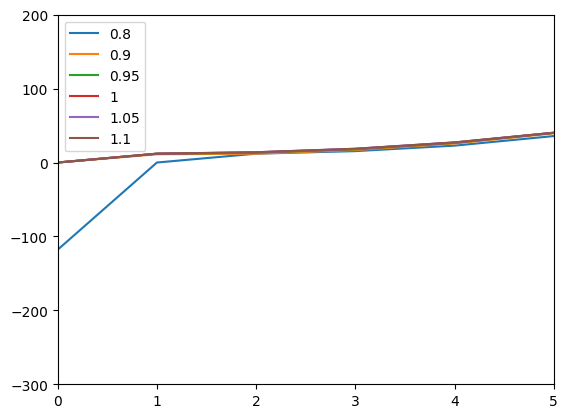

In [37]:
for i in range(len(eigenvalues)):
    plt.plot(range(len(eigenvalues[i])), eigenvalues[i], label=fracs[i])

plt.legend()
plt.xlim([0, 5])
plt.ylim([-300, 200]);

Show that there are no negative modes for the boundary condition q(0) = 0.

In [38]:
eigenvalues = []
eigenvectors = []

fracs = [0.8, 0.9, 0.95, 1, 1.05, 1.1]

for frac in fracs:
    w, v = get_eigenvalues_vectors(frac * b_0_min, boundary_condition='q')
    eigenvalues.append(w)
    eigenvectors.append(v)

In [39]:
for i in range(len(eigenvalues)):
    print(np.any(eigenvalues[i] < 0))

False
False
False
False
False
False


##### Verify Chebyshev differentiation

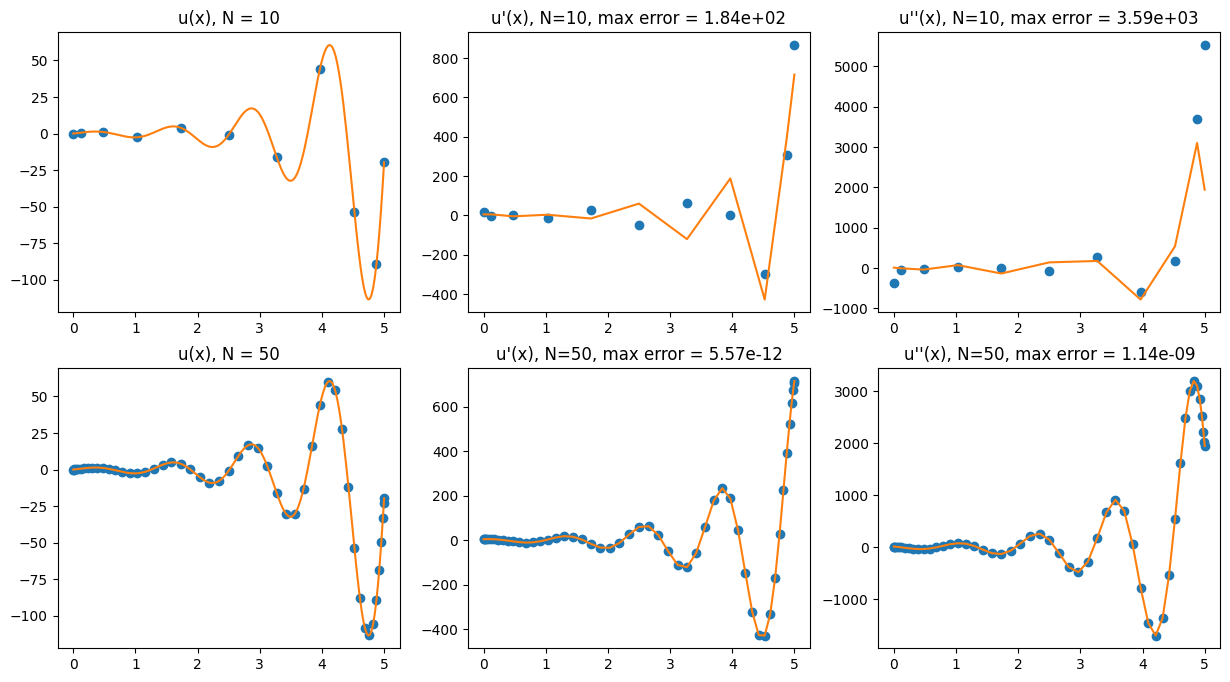

In [40]:
x_min = 0
x_max = 5

xx = np.linspace(x_min, x_max, 200, True)
uu = np.exp(xx) * np.sin(5.0 * xx)

c = 1; plt.figure(figsize=(15, 8))

for N in [10, 50]:
    D, x = cheb(N, x_min, x_max)
    u = np.exp(x) * np.sin(5.0 * x)

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, u, 'o', xx, uu)
    plt.title(f'u(x), N = {N}')

    deriv_est = np.dot(D, u)
    deriv_true = np.exp(x) * (np.sin(5.0 * x) + 5.0 * np.cos(5.0 * x))
    max_error_deriv = np.abs(max(deriv_est - deriv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, deriv_est, 'o', x, deriv_true)
    plt.title(f'u\'(x), N={N}, max error = {max_error_deriv:.2e}')

    dderiv_est = np.dot(D @ D, u)
    dderiv_true = np.exp(x) * (-24.0 * np.sin(5.0 * x) + 10.0 * np.cos(5.0 * x))
    max_error_dderiv = np.abs(max(dderiv_est - dderiv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, dderiv_est, 'o', x, dderiv_true)
    plt.title(f'u\'\'(x), N={N}, max error = {max_error_dderiv:.2e}')

/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarni

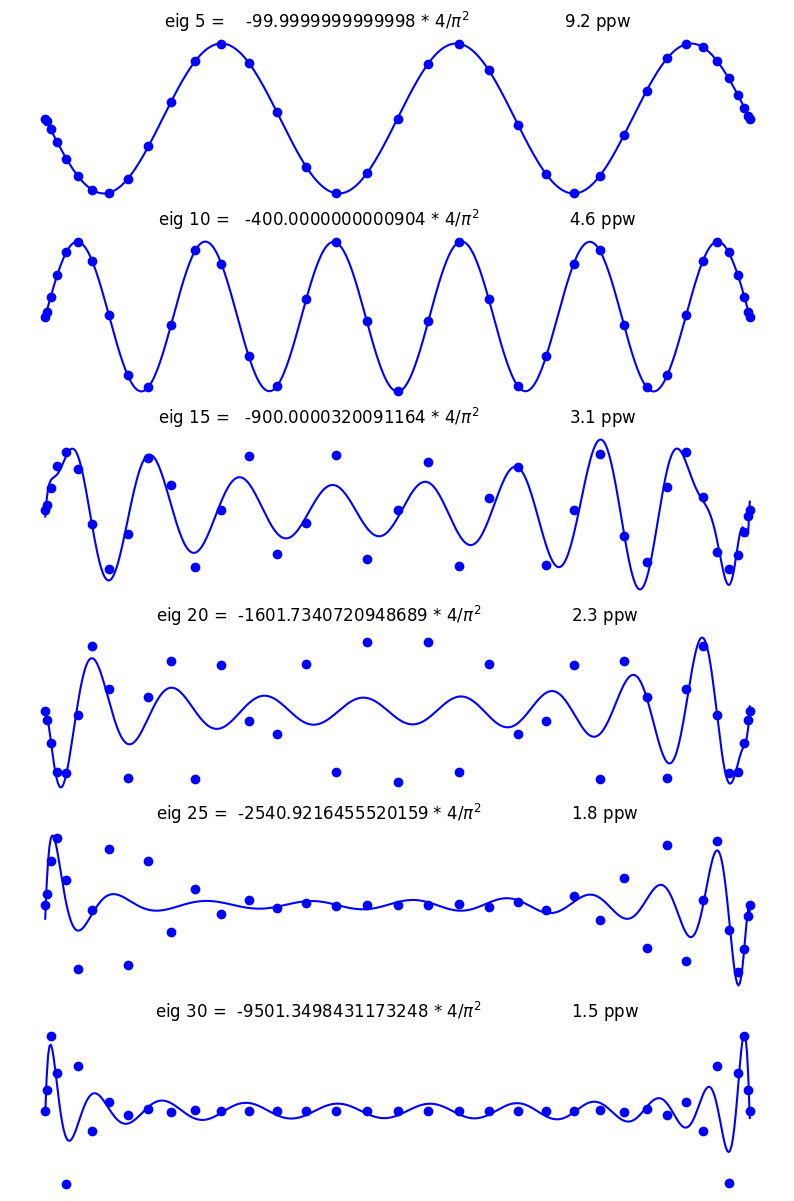

In [41]:
N = 36

x_min = 0
x_max = 1

D, x = cheb(N, x_min, x_max)
D2 = np.dot(D, D)
D2 = D2[1:N, 1:N]

lam, V = linalg.eig(D2)   
ii = np.argsort(-lam)
lam = np.real(lam[ii])
V = V[:, ii]

fig = plt.figure(figsize=(10, 15))
for j in range(5, 35, 5): 
    lv = np.shape(V)[0] + 2
    u = np.zeros(lv)
    u[1:lv - 1] = V[:, int(j)]  

    plt.subplot(6, 1, j//5)
    plt.plot(x, u, 'bo')

    xx = np.linspace(x_min, x_max, 501)
    uu = np.polyval(np.polyfit(x, u, N), xx)    # interpolate grid data
    s = 'eig %d = %20.13f * 4/$\pi^2$' % (j, lam[j-1]*4/np.pi**2)
    s = s + '\t\t %4.1f ppw' % (4*N/(np.pi*j))

    plt.title(s)
    plt.plot(xx,uu,'b')
    plt.axis('off')